### Project Title: 
##### Time Series Analysis: "Demand Forecasting for Inventory Optimization at Corporation Favorita"


### 1. Business Understanding
#### Business Scenario
As data scientists in Corporation Favorita, a large Ecuadorian-based grocery retailer, we are tasked to ensure that there is always the right quantity of products in stock.
To do this we have decided to build a series of machine learning models to forecast the demand of products in various locations.We have been provided with some datasets to help in this project.



#### Project Description
This project aims to ensure optimal inventory levels at Corporation Favorita, by leveraging machine learning models to forecast product demand across various locations. Accurate demand forecasting will help maintain the right quantity of products in stock, reducing instances of overstocking and stockouts, thereby enhancing customer satisfaction and minimizing operational costs. The project follows the CRISP-DM framework and utilizes data provided by the marketing and sales teams to develop and validate predictive models


#### Business Objective
The primary objective of this project is to develop and implement a series of machine learning models to accurately forecast the demand for various products across different locations of Corporation Favorita. By achieving this objective, Corporation Favorita aims to optimize its inventory management, ensuring that the right quantity of products is consistently in stock. 



#### Hypothesis Testing
Null Hypothesis (H0): Promotional activities do not have a significant impact on sales



Alternate Hypothesis (H1): Promotional activities have a significant impact on sales
 

#### Analytical Questions
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

### 2. Data Understanding
#### Sourcing the Dataset
The datasets were sourced from a github repository, a onedrive account, and a SQL server database.

The data at a github repository contains two dattasets; train and transactions

The data at a onedrive  was downloaded manually due to permission issues and contains two datasets also. This is to be used for testing purposes.

The datasets hosted by a SQL server database was queried, and the respective dataframes saved as single files in csv format.

#### File Descriptions and Data Field Information

* train.csv: The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

* store_nbr: identifies the store at which the products are sold.

* family: identifies the type of product sold.

* sales: gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

* onpromotion: gives the total number of items in a product family that were being promoted at a store at a given date.

* test.csv: The test data, having the same features as the training data. You will predict the target sales for the dates in this file.

NB: The dates in the test data are for the 15 days after the last date in the training data.

* transaction.csv: Contains date, store_nbr and transaction made on that specific date.

* sample_submission.csv: A sample submission file in the correct format.

* stores.csv: Store metadata, including city, state, type, and cluster.

* cluster: is a grouping of similar stores.

* oil.csv: Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

* holidays_events.csv: Holidays and Events, with metadata

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
Additional Notes

Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [2]:
### Install required packages
# !pip install statsmodels


#Libraries for sql
# database connections
import pyodbc    
from dotenv import dotenv_values
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ValueWarning

#libraries for handling data
import pandas as pd
import numpy as np

##data visualizations
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import calplot

# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA 

#stat models
# from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import ttest_ind

# Error evaluations
from sklearn.metrics import mean_squared_error, mean_squared_log_error,mean_squared_log_error, mean_absolute_error

# Modelling
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

import joblib

Data from SQL Server database

In [ ]:
# # #Loading first dataset from database
# # Load environment variables from .env file
# environment_variables = dotenv_values(".env")

# # # Access database credentials from environment variables dictionary
# server = environment_variables.get("SERVER")
# username = environment_variables.get("USERNAME")
# password = environment_variables.get("PASSWORD")
# database = environment_variables.get("DATABASE")

# ## Create a connection string
# connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

# # Connect to the database
# # try:
#     # connection = pyodbc.connect(connection_string) 
#     # print("Connection successful!:", connection_string)
# # except Exception as e:
# #     print("Error:", e) 

# # # Specify the SQL queries to extract data from the tables
# oil_data = "SELECT * FROM dbo.oil"
# holiday_data = "SELECT * FROM dbo.holidays_events"
# store_data = "SELECT * FROM dbo.store"

# # # Suppress warnings
# warnings.filterwarnings('ignore')

# # # Create a cursor from the connection
# # with connection.cursor() as cursor: 
#     # Execute the queries and fetch data into Pandas DataFrames
# oil_data = pd.read_sql_query(oil_data, connection)
# holiday_data = pd.read_sql_query(holiday_data, connection)
# store_data = pd.read_sql_query(store_data, connection) 

In [ ]:
# # Load environment variables from .env file into a dictionary
# environment_variables = dotenv_values('.env')

# # Get the values for the credentials you set in the '.env' file
# server = environment_variables.get("SERVER")
# database = environment_variables.get("DATABASE")
# username = environment_variables.get("USERNAME")
# password = environment_variables.get("PASSWORD")

# # Create a connection string
# connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

# # setup connection
# connector = pyodbc.connect(connection_string)

In [149]:
# # Now the sql query to get the data is what what you see below. 
# query = "SELECT * FROM dbo.oil"
# query1 = "SELECT * FROM dbo.holidays_events"
# query2 = "SELECT * FROM dbo.stores" 

In [5]:
holiday_data = pd.read_csv("holiday_data.csv")
holiday_data

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [6]:
stores_data = pd.read_csv("stores_data.csv")
stores_data.head(7)

,Unnamed: 0,store_nbr,city,state,type,cluster
0,0,1,Quito,Pichincha,D,13
1,1,2,Quito,Pichincha,D,13
2,2,3,Quito,Pichincha,D,8
3,3,4,Quito,Pichincha,D,9
4,4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,5,6,Quito,Pichincha,D,13
6,6,7,Quito,Pichincha,D,8


In [7]:
oil_data = pd.read_csv("oil_data.csv")
oil_data

,Unnamed: 0,date,dcoilwtico
0,0,2013-01-01,NaN
1,1,2013-01-02,93.139999
2,2,2013-01-03,92.970001
3,3,2013-01-04,93.120003
4,4,2013-01-07,93.199997
...,...,...,...
1213,1213,2017-08-25,47.650002
1214,1214,2017-08-28,46.400002
1215,1215,2017-08-29,46.459999
1216,1216,2017-08-30,45.959999


Load data from Github

In [8]:
transactions_data = pd.read_csv("transactions.csv")
transactions_data

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [9]:
train_data = pd.read_csv("train.csv")
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Load test data from Onedrive 

In [10]:
test_data = pd.read_csv("test.csv")
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


#### Exploratory Data Analysis (EDA)

The Train Data

In [11]:
# Check for nulls in the train_data 
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [12]:
#Check for duplicates in the train_data

train_data.duplicated().sum()

np.int64(0)

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [14]:
# The date column has the wrong datatype, needs to be converted to datetime

train_data["date"] = pd.to_datetime(train_data["date"])

# Confirm dtype
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [15]:
# date column has correct values now, get all unique values
train_data['date'].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00',
 ...
 '2017-08-06 00:00:00', '2017-08-07 00:00:00', '2017-08-08 00:00:00',
 '2017-08-09 00:00:00', '2017-08-10 00:00:00', '2017-08-11 00:00:00',
 '2017-08-12 00:00:00', '2017-08-13 00:00:00', '2017-08-14 00:00:00',
 '2017-08-15 00:00:00']
Length: 1684, dtype: datetime64[ns]

In [16]:
# see all unique values in store_nbr column
train_data['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [17]:
# see all unique values in family column
train_data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [18]:
#Check statistics of train_data
train_data.describe().T

,count,mean,min,25%,50%,75%,max,std
id,3000888.0,1500443.5,0.0,750221.75,1500443.5,2250665.25,3000887.0,866281.891642
date,3000888,2015-04-24 08:27:04.703088384,2013-01-01 00:00:00,2014-02-26 18:00:00,2015-04-24 12:00:00,2016-06-19 06:00:00,2017-08-15 00:00:00,NaN
store_nbr,3000888.0,27.5,1.0,14.0,27.5,41.0,54.0,15.585787
sales,3000888.0,357.775749,0.0,0.0,11.0,195.84725,124717.0,1101.997721
onpromotion,3000888.0,2.60277,0.0,0.0,0.0,0.0,741.0,12.218882


#### Observation:
* The id variable ranges from 0 to 3,000,887, with a uniform distribution around the mean value of 1,500,444.
* The store_nbr variable ranges from 1 to 54, suggesting there are 54 stores represented in the data.
* The sales variable has a wide range (0 to 124,717) with a high standard deviation, indicating significant variability in sales amounts.
* The onpromotion variable also has a wide range (0 to 741) but a median and 75th percentile of 0, indicating that the majority of entries have no promotions, with a few having a large number of promotions.

In [19]:
#Sorting the index
train_data = train_data.sort_index(ascending=True)

The transactions data

In [20]:
#Check dataset
transactions_data.head(7)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143


In [21]:
#Check info
transactions_data.info()

#  date has wrong dtype in transactions


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [22]:
#Convert the date column to datetime
transactions_data["date"] = pd.to_datetime(transactions_data["date"])

# Confirm change
transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [23]:
#Check for null values
transactions_data.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [24]:
#Check for duplicates
transactions_data.duplicated().sum()

np.int64(0)

The Oil Data

In [25]:
#Check dataset
oil_data.head()

,Unnamed: 0,date,dcoilwtico
0,0,2013-01-01,NaN
1,1,2013-01-02,93.139999
2,2,2013-01-03,92.970001
3,3,2013-01-04,93.120003
4,4,2013-01-07,93.199997


In [26]:
#Check cell values
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1218 non-null   int64  
 1   date        1218 non-null   object 
 2   dcoilwtico  1175 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.7+ KB


Observation: 
* The date column has the wrong datatype, this needs to be corrected.
* There is also an unnamed column in the dataset. This will be removed after confirming it unique values

In [27]:
#Convert the date column to datetime
oil_data["date"] = pd.to_datetime(oil_data["date"])

#Confirm change made
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1218 non-null   int64         
 1   date        1218 non-null   datetime64[ns]
 2   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.7 KB


In [28]:
#Check for nulls in the oil dataset
oil_data.isnull().sum()

Unnamed: 0     0
date           0
dcoilwtico    43
dtype: int64

dcoilwtico colmun in oil_data has 43 missing values

In [29]:
#  set date as the index column
oil_data.set_index('date', inplace=True)


In [30]:
oil_data.head(7)

,Unnamed: 0,dcoilwtico
date,,
2013-01-01,0,NaN
2013-01-02,1,93.139999
2013-01-03,2,92.970001
2013-01-04,3,93.120003
2013-01-07,4,93.199997
2013-01-08,5,93.209999
2013-01-09,6,93.080002


The Stores Data

In [31]:
#Check dataset
stores_data.head(7)

,Unnamed: 0,store_nbr,city,state,type,cluster
0,0,1,Quito,Pichincha,D,13
1,1,2,Quito,Pichincha,D,13
2,2,3,Quito,Pichincha,D,8
3,3,4,Quito,Pichincha,D,9
4,4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,5,6,Quito,Pichincha,D,13
6,6,7,Quito,Pichincha,D,8


In [32]:
#Checking cell values and dtypes
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  54 non-null     int64 
 1   store_nbr   54 non-null     int64 
 2   city        54 non-null     object
 3   state       54 non-null     object
 4   type        54 non-null     object
 5   cluster     54 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 2.7+ KB


In [33]:
#Check for nulls in the stores_data
stores_data.isnull().sum()

Unnamed: 0    0
store_nbr     0
city          0
state         0
type          0
cluster       0
dtype: int64

In [34]:
#Check for duplicates in the stores dataset
stores_data.duplicated().sum()

np.int64(0)

In [35]:
# see all unique values in store_nbr column 
stores_data['store_nbr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [36]:
# see all unique elements in city column
stores_data['city'].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [37]:
# see all unique elements in state column
stores_data['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [38]:
# see all unique elements in type column
stores_data['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [39]:
# see all unique values in cluster column
stores_data['cluster'].unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17])

The holiday data

In [40]:
#Check the dataset
holiday_data.head(7)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False


In [41]:
#Check info
holiday_data.info()

#  date has a wrong dtype here too

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [42]:
#Convert the date column to datetime
holiday_data["date"] = pd.to_datetime(holiday_data["date"])

#Confirm change made
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [43]:
#Check for nulls in the holiday data
holiday_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [44]:
#Check for duplicates in the holiday  data
holiday_data.duplicated().sum()

np.int64(0)

### Univariate Analysis

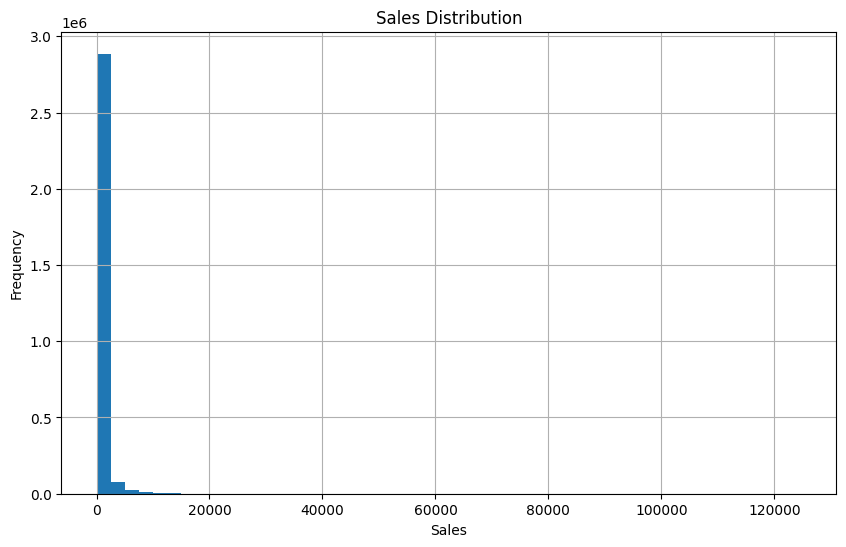

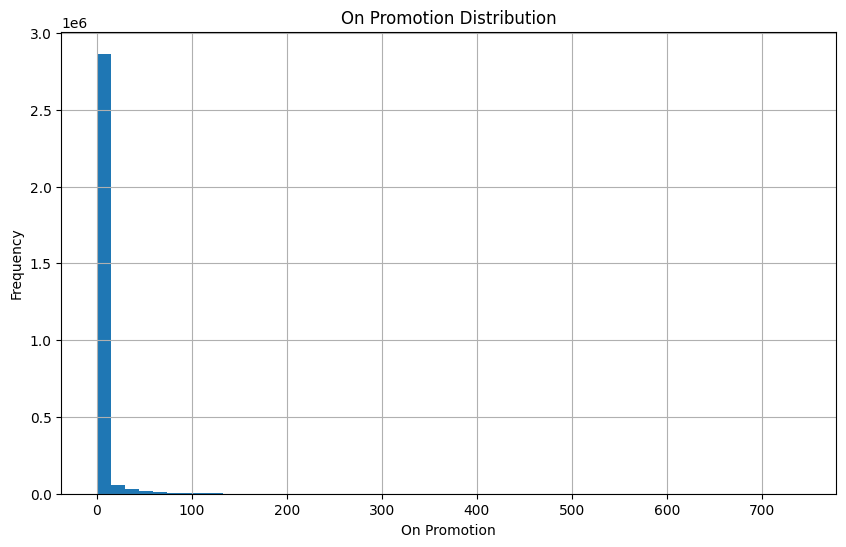

In [155]:
#Histogram for 'sales'
plt.figure(figsize=(10, 6)) 
train_data['sales'].hist(bins=50)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

#Histogram for 'onpromotion'
plt.figure(figsize=(10, 6))
train_data['onpromotion'].hist(bins=50)
plt.title('On Promotion Distribution')
plt.xlabel('On Promotion')
plt.ylabel('Frequency')
plt.show()


Observations;
* The majority of the sales values are concentrated near zero, indicating that either many items did not sell or had very low sales.
* The histogram is right-skewed, with a long tail extending towards higher sales values. This indicates that while most sales are low, there are some occurrences of significantly higher sales values. These outliers are much less frequent.
* Similar to the sales histogram, the majority of the onpromotion values are concentrated at the lower end, particularly near zero. A large number of records have zero or very few items on promotion.
* The histogram is right-skewed, with a long tail extending towards higher values. While most records have low values for onpromotion, there are some instances where a significantly higher number of items are on promotion. These higher values are less frequent but present.

Box Plots to identify the Spread and Outliers in the Sales and Onpromotion Columns.

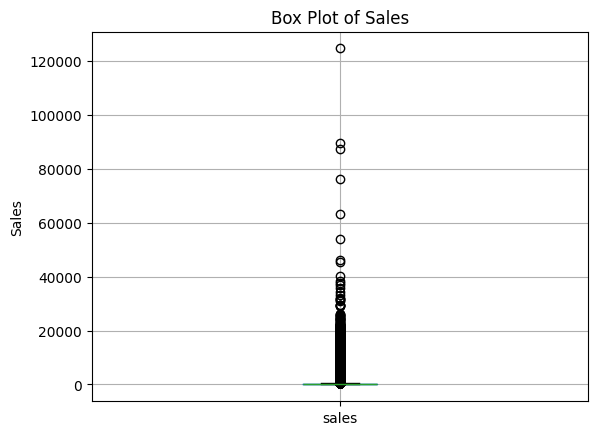

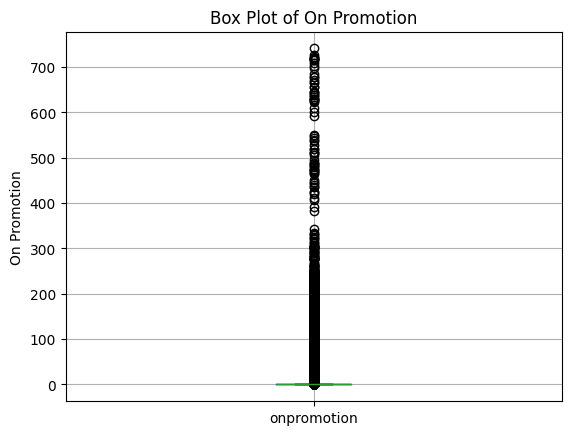

In [46]:
#Box plot for 'sales'
train_data.boxplot(column='sales')
plt.title('Box Plot of Sales')
plt.ylabel('Sales')
plt.show()

#Box plot for 'onpromotion'
train_data.boxplot(column='onpromotion')
plt.title('Box Plot of On Promotion')
plt.ylabel('On Promotion')
plt.show()

Observations;
* The majority of the sales data points are concentrated at the lower end, with a small range of typical sales values as indicated by the box.
* The high number of outliers shows that there are instances with very high sales, suggesting rare but significant peaks in sales.
* Majority of the data points for "onpromotion" are clustered around the lower values, with a few stores having exceptionally high promotional activity.

#### Analysing the Trend of Sales Over Time

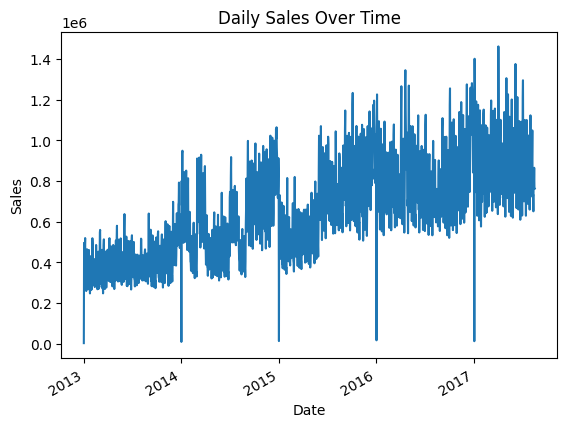

In [47]:
#Group by date and sum sales
daily_sales = train_data.groupby('date')['sales'].sum()

#Time series plot of daily sales
daily_sales.plot()
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Observations;
* Sales are progressively increasing from 2013 to 2017.
* There are regular peaks and troughs throughout each year. This suggests seasonality, where certain times of the year consistently show higher sales.
* Notable dips to near zero occur at regular intervals, likely representing specific events such as holidays when stores might be closed, or regular patterns of very low sales days.

#### Bivariate Analysis

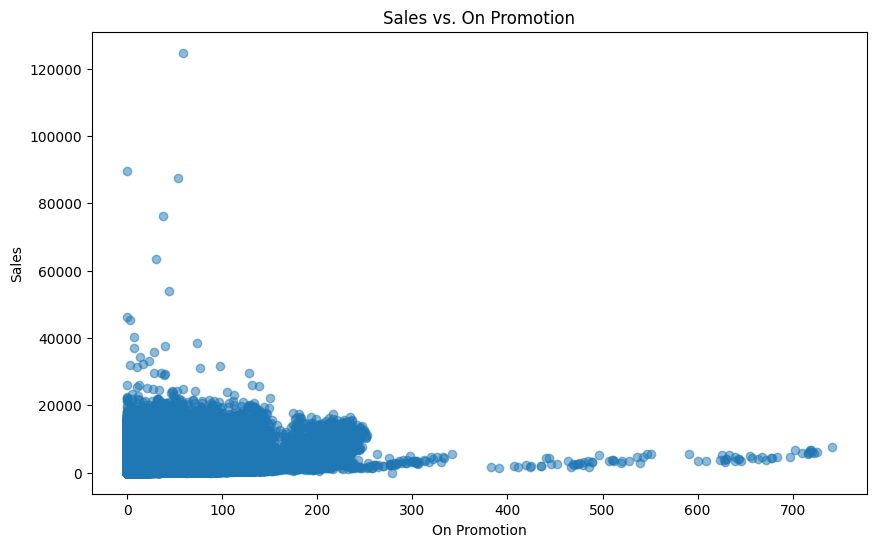

In [48]:
#Scatter plot between sales and onpromotion
plt.figure(figsize=(10, 6))
plt.scatter(train_data['onpromotion'], train_data['sales'], alpha=0.5)
plt.title('Sales vs. On Promotion')
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.show()

Observations;
* The majority of data points are clustered at the lower end of the 'On Promotion' axis, with most of the sales occurring when the number of items on promotion is low.
* There is a high density of points at the lower left corner, indicating that for most dates or data entries, a relatively small number of items are on promotion.

##### Box Plot for Sales by Day of the Week

<Figure size 1000x600 with 0 Axes>

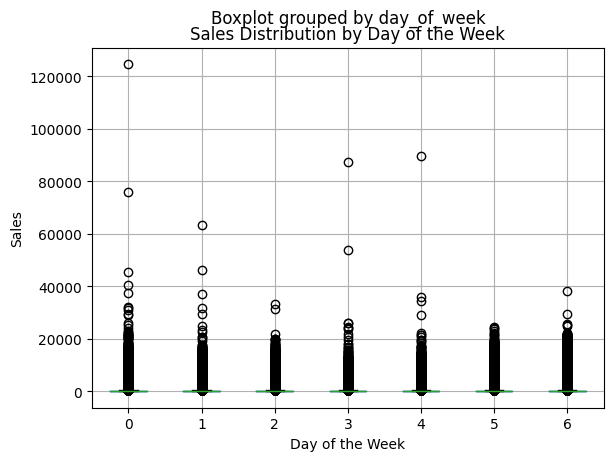

In [49]:
# Convert 'date' column to datetime
train_data['date'] = pd.to_datetime(train_data['date'])

# Set the 'date' column as the index
train_data.set_index('date', inplace=True)

# Create a new column for the day of the week
train_data['day_of_week'] = train_data.index.dayofweek

# Box plot for sales by day of the week
plt.figure(figsize=(10, 6))
train_data.boxplot(column='sales', by='day_of_week')
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()

### Multivariate Analysis
Principal Component Analysis

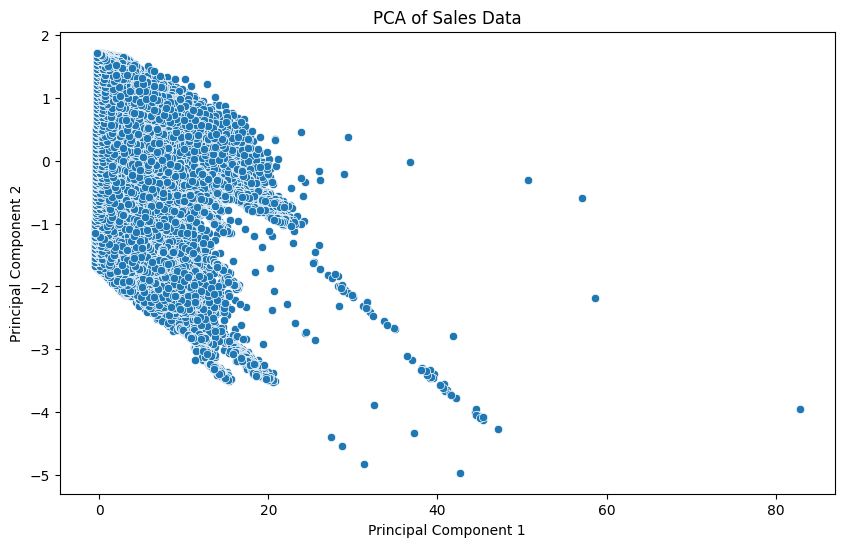

In [147]:

#Select numeric features and standardize them
features = ['sales', 'onpromotion', 'store_nbr']
x = StandardScaler().fit_transform(train_data[features])

#Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

#Create a DataFrame with principal components
principal_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

#Plot the principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='principal_component_1', y='principal_component_2', data=principal_df)
plt.title('PCA of Sales Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Observation;

Principal Component 1 captures the largest amount of variance in the data. This means it is the linear combination of the original features that explains the most variability.
Principal Component 2 captures the second largest amount of variance, orthogonal to Principal Component 1.
Spread and Clustering:

The majority of the data points are clustered towards the lower values of Principal Component 1, indicating that most of the variance is concentrated in this region.
There are some points that are spread out towards higher values of Principal Component 1 and lower values of Principal Component 2, suggesting the presence of some outliers or data points that significantly differ from the main cluster.


This scatter plot provides a visual summary of the sales data after applying PCA. It reduces the complexity of the dataset while retaining significant variance, making it easier to observe patterns, clusters, and outliers in the data. Further analysis can be conducted based on these observations, such as investigating outliers or exploring the relationships between the original features.

## f

### Data Preparation

We have already noticed there are no missing values in the all datasets  except oil_data (43 null) from the EDA made above

In [52]:
oil_data.isna().sum()

Unnamed: 0     0
dcoilwtico    43
dtype: int64

In [53]:
#Check the statistical values in the oil data
oil_data.describe()

,Unnamed: 0,dcoilwtico
count,1218.000000,1175.000000
mean,608.500000,67.714366
std,351.750622,25.630476
min,0.000000,26.190001
25%,304.250000,46.405001
50%,608.500000,53.189999
75%,912.750000,95.660000
max,1217.000000,110.620003


In [54]:
oil_data['dcoilwtico']

date
2013-01-01          NaN
2013-01-02    93.139999
2013-01-03    92.970001
2013-01-04    93.120003
2013-01-07    93.199997
                ...    
2017-08-25    47.650002
2017-08-28    46.400002
2017-08-29    46.459999
2017-08-30    45.959999
2017-08-31    47.259998
Name: dcoilwtico, Length: 1218, dtype: float64

In [55]:
#Replace nan value with np.nan
oil_data.replace('nan', np.nan, inplace=True)

#Fill null values with forward fill
oil_data = oil_data.fillna(method = 'ffill')

In [56]:
oil_data.isna().sum()

Unnamed: 0    0
dcoilwtico    1
dtype: int64

In [58]:
oil_data.head(7)

,Unnamed: 0,dcoilwtico
date,,
2013-01-01,0,NaN
2013-01-02,1,93.139999
2013-01-03,2,92.970001
2013-01-04,3,93.120003
2013-01-07,4,93.199997
2013-01-08,5,93.209999
2013-01-09,6,93.080002


In [59]:
#Single missing value is at the start of the dataframe so fill with backward fill 
oil_data = oil_data.fillna(method = 'bfill')

In [60]:
# confirm missing value filled
oil_data.isna().sum()

Unnamed: 0    0
dcoilwtico    0
dtype: int64

In [61]:
oil_data.head(7)

,Unnamed: 0,dcoilwtico
date,,
2013-01-01,0,93.139999
2013-01-02,1,93.139999
2013-01-03,2,92.970001
2013-01-04,3,93.120003
2013-01-07,4,93.199997
2013-01-08,5,93.209999
2013-01-09,6,93.080002


In [62]:
#Drop the unnamed column
oil_data.drop(columns=['Unnamed: 0'], inplace=True)

In [63]:
oil_data.head(7)

,dcoilwtico
date,
2013-01-01,93.139999
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997
2013-01-08,93.209999
2013-01-09,93.080002


In [64]:
test_data.head(7)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12
6,3000894,2017-08-16,1,CELEBRATION,0


In [65]:
#Make date the index the test data
test_data.set_index('date', inplace=True)

In [66]:
test_data.head(7)

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0
2017-08-16,3000893,1,BREAD/BAKERY,12
2017-08-16,3000894,1,CELEBRATION,0


################

In [67]:
train_data.head(7)

,id,store_nbr,family,sales,onpromotion,day_of_week
date,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,1
2013-01-01,1,1,BABY CARE,0.0,0,1
2013-01-01,2,1,BEAUTY,0.0,0,1
2013-01-01,3,1,BEVERAGES,0.0,0,1
2013-01-01,4,1,BOOKS,0.0,0,1
2013-01-01,5,1,BREAD/BAKERY,0.0,0,1
2013-01-01,6,1,CELEBRATION,0.0,0,1


In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
 5   day_of_week  int32  
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 148.8+ MB


Checking Stationarity in Dataset


In [ ]:
# #  'date' is your datetime column
# train_data['date'] = pd.to_datetime(train_data['date'])

# # Setting the datetime column as the index
# train_data.set_index('date', inplace=True)

In [70]:
#Downsampling the dataset to monthly frequency to check for stationarity
df_monthly = train_data['sales'].resample('M').mean()

#Applying the ADF test to the downsampled dataset
result = adfuller(df_monthly.dropna())

#Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result [1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -1.574663931940097
p-value: 0.4963069089455667
Data is not stationary


In [71]:
#Downsampling the dataset to weekly frequency to check for stationarity
df_weekly = train_data['sales'].resample('W').mean()

#Applying the ADF test to the downsampled dataset
result = adfuller(df_weekly.dropna())

#Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result [1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -1.5903747027604562
p-value: 0.48842681062681376
Data is not stationary


In [72]:
#Downsampling the dataset to daily frequency to check for stationarity
df_daily = train_data['sales'].resample('D').mean()

# Applying the ADF test to the downsampled dataset
result = adfuller(df_daily.dropna())

# Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result [1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -2.6161957486048673
p-value: 0.08969592175787261
Data is not stationary


Using Rolling Statistics to visualize Stationarity

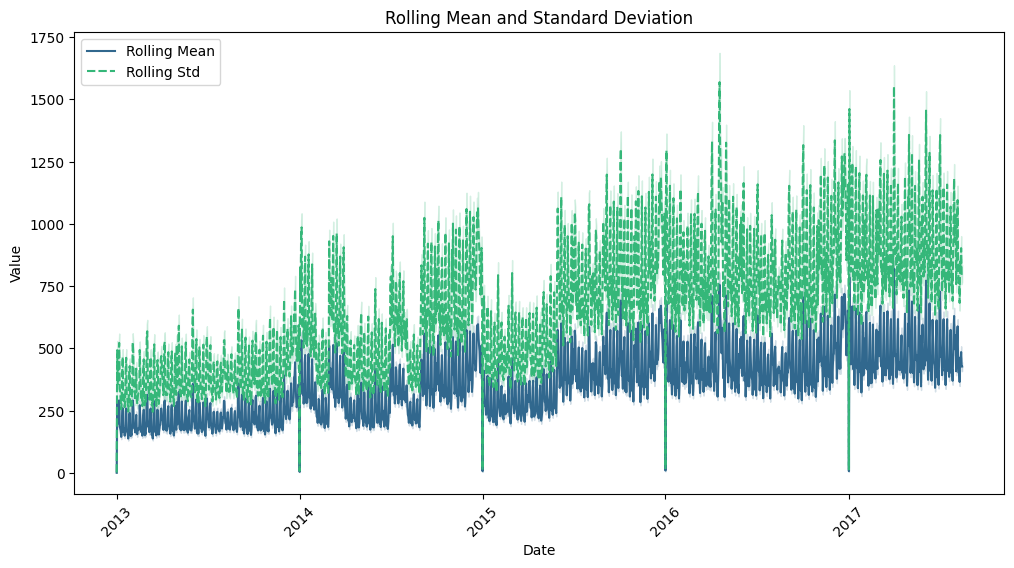

In [73]:
rolling_mean = train_data["sales"].rolling(window=7).mean()
rolling_std = train_data["sales"].rolling(window=7).std()

#Create a new DataFrame for the rolling statistics
rolling_stats = pd.DataFrame({'Rolling Mean': rolling_mean, 'Rolling Std': rolling_std})

#Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_stats, palette="viridis")
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

Observation;

The rolling mean smooths out short-term fluctuations and highlights longer-term trends or cycles in the data.
The solid line shows how the average value changes over time. From the chart, the rolling mean generally increases from 2013 to 2017, indicating a rising trend in the underlying data values.

The rolling standard deviation shows a more gradual increase in variability, indicating that the data values are more spread out over time. It measures variability or dispersion of the data over the rolling window.
The dashed line shows how the standard deviation changes over time. A higher standard deviation indicates more variability or volatility in the data. In the chart, you can see that the variability also increases over time.

The dataset is not stationary(the mean and covariance or Standard Deviation does not remain constant over time).


### Hypothesis Testing
Null Hypothesis (H0): Promotional activities do not have a significant impact on sales



Alternate Hypothesis (H1): Promotional activities have a significant impact on sales

In [74]:
#Split Promoted items and those that were not promoted
train_data['onpromotion_encoded'] = np.where(train_data['onpromotion'] >= 1, 1, 0)
train_data['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    2389559
1     611329
Name: count, dtype: int64

In [75]:
# Extract the relevant variables for the hypothesis test
sales_on_promotion = train_data[train_data['onpromotion_encoded'] == 1]['sales']
sales_not_on_promotion = train_data[train_data['onpromotion_encoded'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(sales_on_promotion, sales_not_on_promotion) 

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): Promotional activities do not have a significant impact on sales.")
print("Alternative Hypothesis (H1): Promotional activities have a significant impact on sales.")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print(" We reject the null hypothesis.")
    print("Promotional activities have a significant impact on sales at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis.")
    print("Promotional activities do not have a significant impact on sales at Corporation Favorita.")      
          

Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): Promotional activities do not have a significant impact on sales.
Alternative Hypothesis (H1): Promotional activities have a significant impact on sales.
--------------------------------------------------
Test Statistic: 664.1236909096903
P-value: 0.0
 We reject the null hypothesis.
Promotional activities have a significant impact on sales at Corporation Favorita.


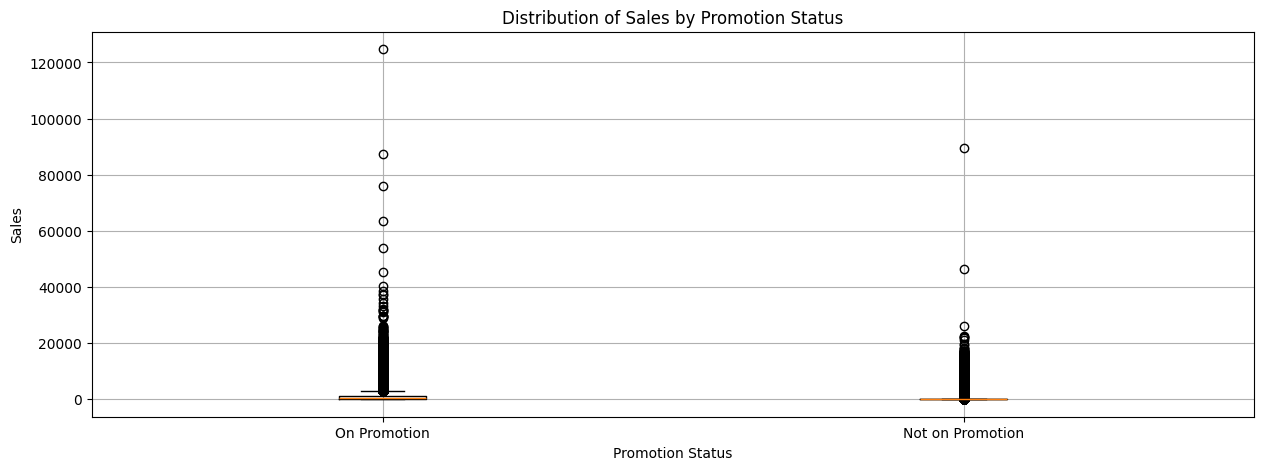

In [76]:
#Create a box plot for sales on promotion and sales not on promotion
plt.figure(figsize=(15, 5))
plt.boxplot([sales_on_promotion, sales_not_on_promotion], labels=['On Promotion', 'Not on Promotion'])
plt.title('Distribution of Sales by Promotion Status')
plt.ylabel('Sales')
plt.xlabel('Promotion Status')
plt.grid(True)
plt.show()

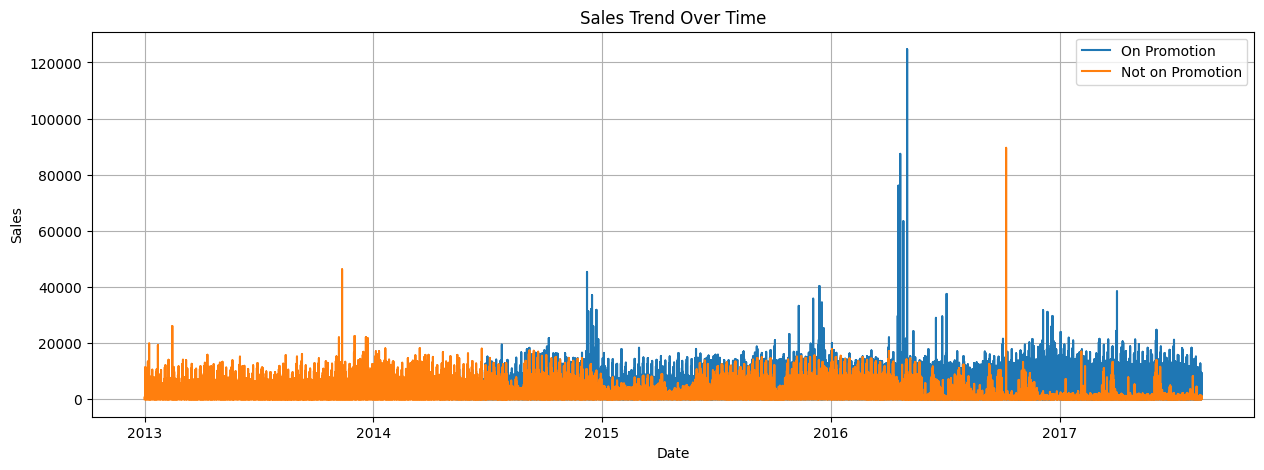

In [77]:
# Plot sales trend over time for items on promotion and items not on promotion
plt.figure(figsize=(15, 5))
plt.plot(train_data[train_data['onpromotion_encoded'] == 1].index, sales_on_promotion, label='On Promotion')
plt.plot(train_data[train_data['onpromotion_encoded'] == 0].index, sales_not_on_promotion, label='Not on Promotion')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Observations;
* It's clear that promotion activities have positive impact on sales.
* There are more sales resulting from promotions as compared to to non-promotion activities. 

### Merge the datasets

In [78]:
#Merge the train and transactions datasets based on the date and store number columns
merged = pd.merge(train_data, transactions_data, on=['date', 'store_nbr'])

In [79]:
merged.head()

,date,id,store_nbr,family,sales,onpromotion,day_of_week,onpromotion_encoded,transactions
0,2013-01-01,561,25,AUTOMOTIVE,0.0,0,1,0,770
1,2013-01-01,562,25,BABY CARE,0.0,0,1,0,770
2,2013-01-01,563,25,BEAUTY,2.0,0,1,0,770
3,2013-01-01,564,25,BEVERAGES,810.0,0,1,0,770
4,2013-01-01,565,25,BOOKS,0.0,0,1,0,770


In [80]:
#Drop the onpromotion_encoded column
merged.drop('onpromotion_encoded', axis=1, inplace=True)

In [81]:
#  confirm drop change
merged.head()

,date,id,store_nbr,family,sales,onpromotion,day_of_week,transactions
0,2013-01-01,561,25,AUTOMOTIVE,0.0,0,1,770
1,2013-01-01,562,25,BABY CARE,0.0,0,1,770
2,2013-01-01,563,25,BEAUTY,2.0,0,1,770
3,2013-01-01,564,25,BEVERAGES,810.0,0,1,770
4,2013-01-01,565,25,BOOKS,0.0,0,1,770


In [82]:
#Merge the merged dataframe with the holiday dataframe based on the date column
merged = pd.merge(merged, holiday_data, on='date')

In [83]:
#  confirm merging of datasets
merged.head()

,date,id,store_nbr,family,sales,onpromotion,day_of_week,transactions,type,locale,locale_name,description,transferred
0,2013-01-01,561,25,AUTOMOTIVE,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,562,25,BABY CARE,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,563,25,BEAUTY,2.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,564,25,BEVERAGES,810.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,565,25,BOOKS,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False


In [84]:
#Merge the merged data with the oil dataframe on the date column
merged = pd.merge(merged, oil_data, on='date')

# confirm merging
merged.head()


,date,id,store_nbr,family,sales,onpromotion,day_of_week,transactions,type,locale,locale_name,description,transferred,dcoilwtico
0,2013-01-01,561,25,AUTOMOTIVE,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
1,2013-01-01,562,25,BABY CARE,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2,2013-01-01,563,25,BEAUTY,2.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
3,2013-01-01,564,25,BEVERAGES,810.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
4,2013-01-01,565,25,BOOKS,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


In [85]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   id            322047 non-null  int64         
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   day_of_week   322047 non-null  int32         
 7   transactions  322047 non-null  int64         
 8   type          322047 non-null  object        
 9   locale        322047 non-null  object        
 10  locale_name   322047 non-null  object        
 11  description   322047 non-null  object        
 12  transferred   322047 non-null  bool          
 13  dcoilwtico    322047 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int32(1), int64(4), objec

In [86]:
#Merge the merged data with the stores dataframe on the stores number column(store_nbr) 
train_df = pd.merge(merged, stores_data, on='store_nbr')

In [87]:
# confirm merging
train_df.head()

,date,id,store_nbr,family,sales,onpromotion,day_of_week,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,Unnamed: 0,city,state,type_y,cluster
0,2013-01-01,561,25,AUTOMOTIVE,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,24,Salinas,Santa Elena,D,1
1,2013-01-01,562,25,BABY CARE,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,24,Salinas,Santa Elena,D,1
2,2013-01-01,563,25,BEAUTY,2.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,24,Salinas,Santa Elena,D,1
3,2013-01-01,564,25,BEVERAGES,810.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,24,Salinas,Santa Elena,D,1
4,2013-01-01,565,25,BOOKS,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,24,Salinas,Santa Elena,D,1


In [89]:
train_df.shape

(322047, 19)

In [90]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   id            322047 non-null  int64         
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   day_of_week   322047 non-null  int32         
 7   transactions  322047 non-null  int64         
 8   type_x        322047 non-null  object        
 9   locale        322047 non-null  object        
 10  locale_name   322047 non-null  object        
 11  description   322047 non-null  object        
 12  transferred   322047 non-null  bool          
 13  dcoilwtico    322047 non-null  float64       
 14  Unnamed: 0    322047 non-null  int64         
 15  city          322

In [91]:
#Drop the unnamed colum
train_df.drop(columns=['Unnamed: 0'], inplace=True)

#  confirm change for dropping 'Unnamed: 0' column 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   id            322047 non-null  int64         
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   day_of_week   322047 non-null  int32         
 7   transactions  322047 non-null  int64         
 8   type_x        322047 non-null  object        
 9   locale        322047 non-null  object        
 10  locale_name   322047 non-null  object        
 11  description   322047 non-null  object        
 12  transferred   322047 non-null  bool          
 13  dcoilwtico    322047 non-null  float64       
 14  city          322047 non-null  object        
 15  state         322

In [92]:
train_df.head()

,date,id,store_nbr,family,sales,onpromotion,day_of_week,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,2013-01-01,561,25,AUTOMOTIVE,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
1,2013-01-01,562,25,BABY CARE,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
2,2013-01-01,563,25,BEAUTY,2.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
3,2013-01-01,564,25,BEVERAGES,810.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
4,2013-01-01,565,25,BOOKS,0.0,0,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1


Actions;

* Change type_x column name to holiday_type to reflect what it is in the Holiday dataset.
* Change 'dcoilwtico' column name to reflect what it represents which is oil price.
* Change type_y column name to store_type to reflect what it represents in the stores dataframe. 

In [93]:
#Changing the column names
train_df = train_df.rename(columns= {'type_x': 'holiday_type', 'dcoilwtico': 'oil_price', 'type_y':'store_type' })

In [94]:
#Confirm the change in column names
train_df.columns

Index(['date', 'id', 'store_nbr', 'family', 'sales', 'onpromotion',
       'day_of_week', 'transactions', 'holiday_type', 'locale', 'locale_name',
       'description', 'transferred', 'oil_price', 'city', 'state',
       'store_type', 'cluster'],
      dtype='object')

In [95]:
#Checking for missing values 
train_df.isnull().sum()

date            0
id              0
store_nbr       0
family          0
sales           0
onpromotion     0
day_of_week     0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
oil_price       0
city            0
state           0
store_type      0
cluster         0
dtype: int64

In [96]:
#Checking for duplicates 
train_df.duplicated().sum()

np.int64(0)

### Answering Analytical Questions 
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

1. Is the train dataset complete (has all the required dates)?

In [97]:
#Check for null values in the train dataset
train_data.isnull().sum()

id                     0
store_nbr              0
family                 0
sales                  0
onpromotion            0
day_of_week            0
onpromotion_encoded    0
dtype: int64

In [98]:
#Get the Minimum and the Maximum Dates
train_data.index.min(), train_data.index.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [99]:
#Save the min and max dates in variables
min_date = train_data.index.min()
max_date = train_data.index.max()

#Get the expected number of dates given the min and max dates
expected_dates = pd.date_range(start=min_date, end=max_date, freq='D')

#Get the actual number of dates
print(f"Expected number of unique dates: {len(expected_dates)},\nActual number of unique dates: {len(train_data.index.unique())}")

Expected number of unique dates: 1688,
Actual number of unique dates: 1684


In [100]:
#Checking which dates are missing
train_missing_dates = expected_dates.difference(train_data.index.unique())
train_missing_dates.to_list() 

[Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')]

Observations;
* The minimum date is 2013-01-01, and the maximum date is 2017-08-15. After checking the range of dates between the minimum and maximum dates, we realize that the date column is not complete and is missing 4 dates.
* The missing dates are 2013-12-25, 2014-12-25, 2015-12-25, and 2016-12-25. After checking the missing dates, we realize that the 25th day of every December is missing, presumably because the day is Christmas, and most companies around the world are closed on Christmas.

##### 2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

Dates With the Highest Sales For Each Year
             date  year     sales
36510  2013-11-12  2013   46271.0
107922 2014-12-08  2014   45361.0
166827 2015-11-11  2015   33274.0
217548 2016-05-02  2016  124717.0
286221 2017-01-02  2017   23966.0


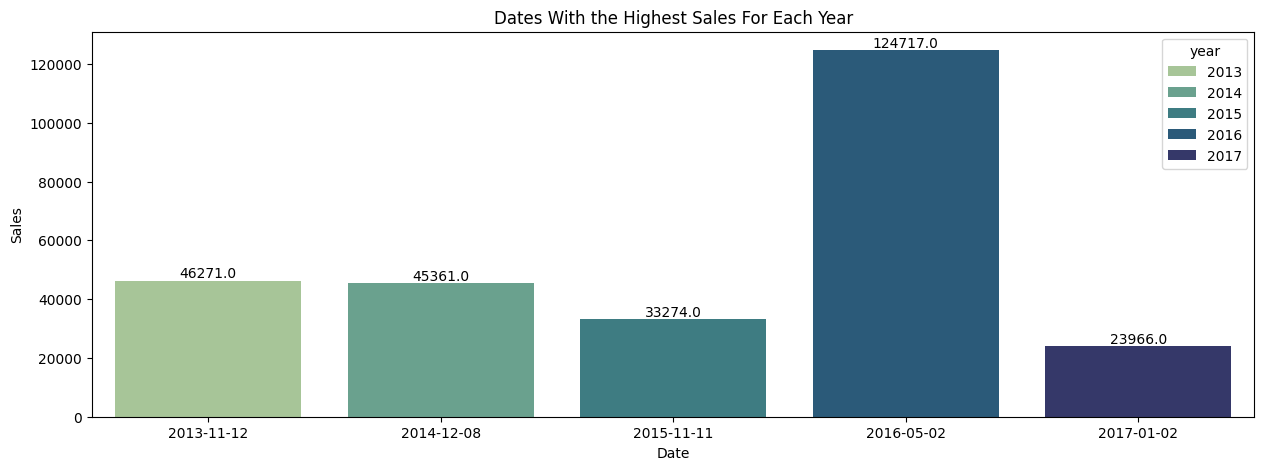

In [101]:
#Create a Year column
train_df['year'] = train_df['date'].dt.year
train_df.reset_index(drop=True, inplace=True)
max_sales= train_df.groupby('year')['sales'].idxmax()
max_sales_rows = train_df.loc[max_sales]

print("Dates With the Highest Sales For Each Year")

print(max_sales_rows[['date', 'year','sales']])

#Visualize the highest sales data by date and year
plt.figure(figsize=(15,5))
sns.barplot(x=max_sales_rows['date'], y=max_sales_rows['sales'], hue=max_sales_rows['year'], palette='crest')
plt.xlabel('Date')
plt.ylabel('Sales')
for index, value in enumerate(max_sales_rows['sales']):
    label = f'{value:.1f}'
    plt.text(index, value, label, ha='center', va='bottom')
plt.title('Dates With the Highest Sales For Each Year')
plt.show()

Dates with the lowest sales for each year (excluding days with zero sales)
             date  year  sales
19370  2013-07-23  2013  0.294
106490 2014-12-05  2014  0.188
152987 2015-08-24  2015  0.300
242285 2016-06-23  2016  0.396
301289 2017-05-01  2017  0.470


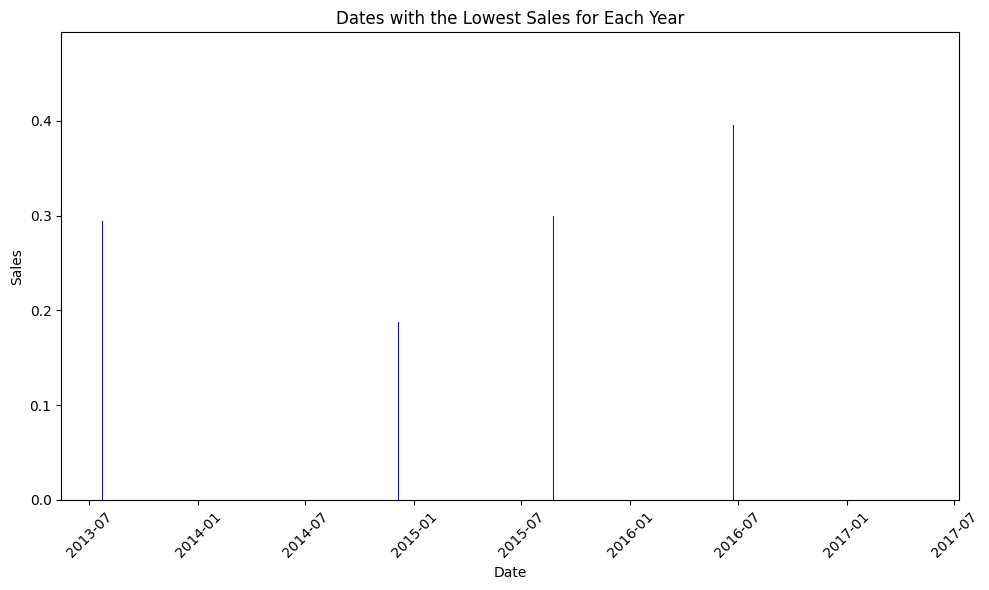

In [103]:
# Filter out rows where sales are greater than 0
non_zero_sales_data = train_df[train_df['sales'] > 0]

# Get the index of the row with the minimum sales for each year
min_sales_idx = non_zero_sales_data.groupby('year')['sales'].idxmin()

# Retrieve the rows with the minimum sales for each year
min_sales_rows = non_zero_sales_data.loc[min_sales_idx]

print("Dates with the lowest sales for each year (excluding days with zero sales)")

print(min_sales_rows[['date', 'year', 'sales']])

# Visualize the lowest sales data by data and year
plt.figure(figsize=(10, 6))
plt.bar(min_sales_rows['date'], min_sales_rows['sales'], color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Dates with the Lowest Sales for Each Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

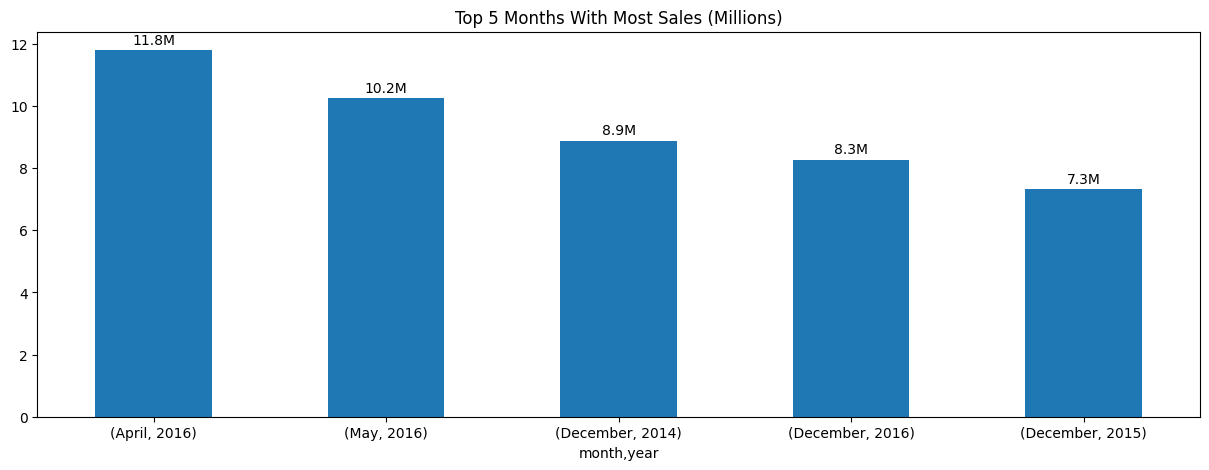

In [104]:
#Creating a column with the month names
train_df['month'] = train_df['date'].dt.month_name()

#Group sales by month and year
monthly_sales = train_df.groupby(['month', 'year'])['sales'].sum().sort_values(ascending=False)

#Convert sales to millions
monthly_sales_millions = monthly_sales / 1000000

#Plotting the monthly sales
plt.figure(figsize=(15, 5))
ax = monthly_sales_millions.head(5).plot.bar()
plt.xticks(rotation=0)
plt.title('Top 5 Months With Most Sales (Millions)')
for i, v in enumerate(monthly_sales_millions.head(5)):
    plt.text(i, v + 0.1, f'{v:.1f}M', ha='center', va='bottom')
plt.show()

#### 4. Did the earthquake impact sales?
* A 7.8 magnitude earthquake hit Ecuador on April 16, 2016. In response, people mobilized for relief efforts, donating water and other essential items, which significantly impacted supermarket sales for several weeks following the disaster.

In [105]:
#Set the 'date' column as the index
train_df.set_index('date', inplace=True)

In [106]:
#Resample to weekly frequency, aggregating with mean
total_weekly_sales = train_df["sales"].resample('W').sum()

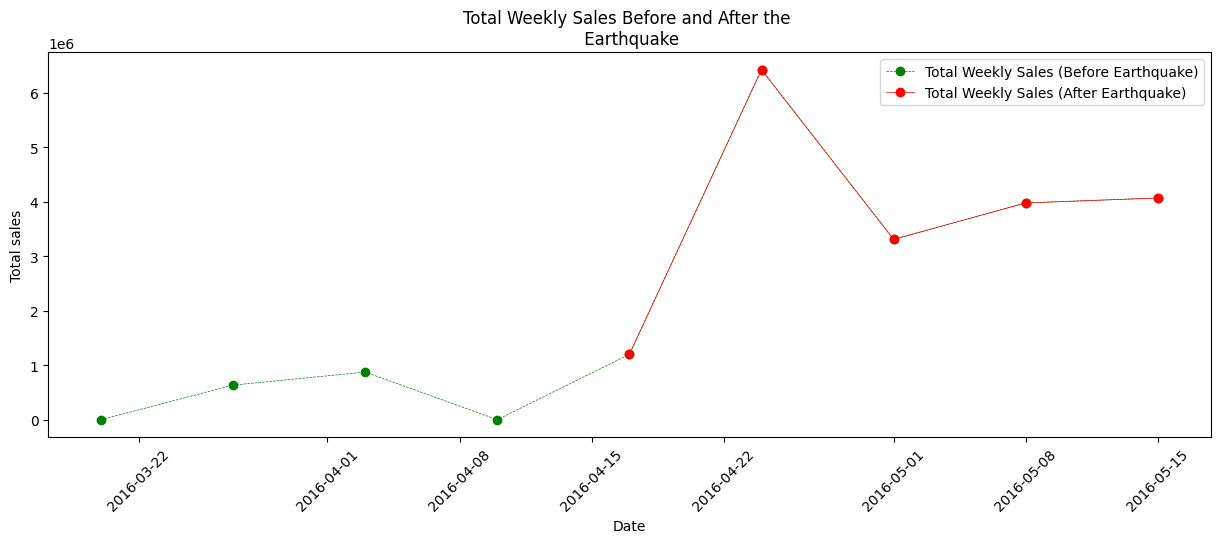

In [116]:
#Date before the earthquake
start = '2016-03-16'

#Date of the earthquake
after = '2016-04-16'  

#End date
end = '2016-05-16'    

#Slicing the data before and after the earthquake date
sales_before_w = total_weekly_sales.loc[start:end]
sales_after_w = total_weekly_sales.loc[after:end]

fig, ax = plt.subplots(figsize=(15, 5))

#Plotting the data before the earthquake date with one color
ax.plot(sales_before_w, marker='o', linestyle='--', linewidth=0.5, label='Total Weekly Sales (Before Earthquake)', color='green')

#Plotting the data after the earthquake date with another color
ax.plot(sales_after_w, linestyle='-', marker='o', linewidth=0.5, label='Total Weekly Sales (After Earthquake)', color='red')

ax.set_ylabel("Total sales")
ax.set_xlabel("Date")
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_title("Total Weekly Sales Before and After the \n Earthquake")

plt.show()

Observations;
* After the earthquake, there was a significant increase in sales the following day.
* However, within a week, sales started to decrease gradually, eventually returning to their pre-earthquake levels.

#### 5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

##### * By Cluster

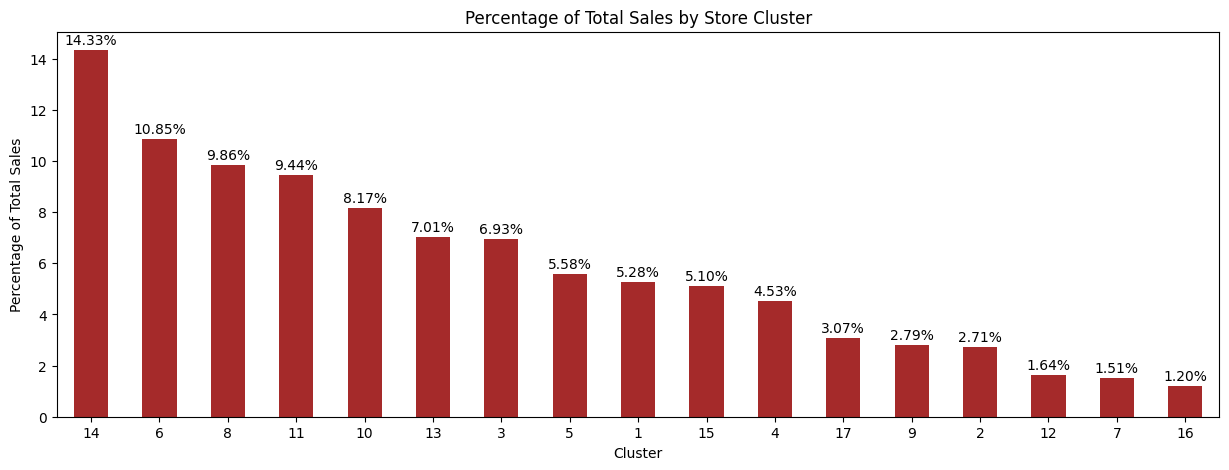

In [109]:
#Calculate total sales by cluster
cluster_sales = train_df.groupby('cluster')['sales'].sum().sort_values(ascending=False)

#Calculate overall total sales
overall_sales = train_df['sales'].sum()

#Calculate the percentage of each cluster's sales over the overall sales
percentage_sales = (cluster_sales / overall_sales) * 100

#Plot a barplot to visualize the percentage of sales by cluster
plt.figure(figsize=(15, 5))
percentage_sales_sorted = percentage_sales.sort_values(ascending=False)
percentage_sales_sorted.plot.bar(color='brown')

#Add labels to the bars
for i, percentage in enumerate(percentage_sales_sorted):
    plt.text(i, percentage + 0.1, f"{percentage:.2f}%", ha='center', va='bottom')

plt.title('Percentage of Total Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Total Sales')
plt.xticks(rotation=0)
plt.show()

Observations;
* There are 17 clusters.
* Clusters 14, 6, and 8 are the top-selling clusters.
* Cluster 14 is the top seller, accounting for 14.33% of total sales, followed by cluster 6 with 10.85%, and cluster 8 with 9.86%.
* The three lowest-selling clusters are 12, 7, and 16, each contributing less than 2% of total sales.

#### * By City

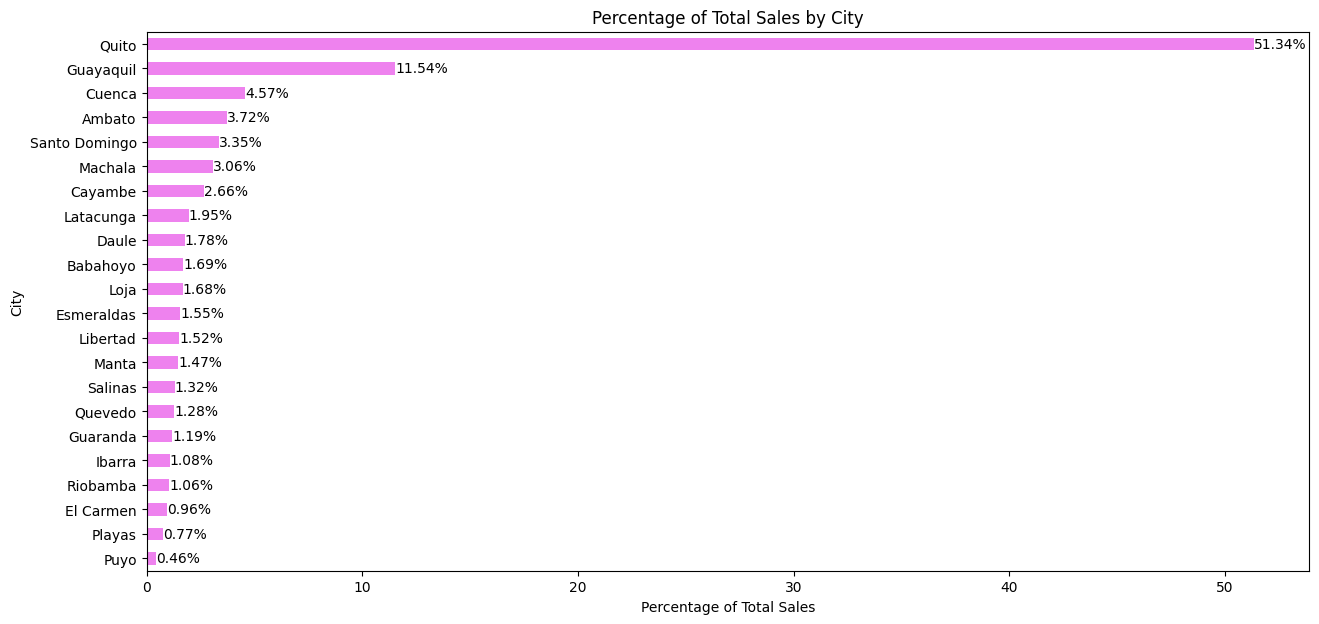

In [112]:
#Calculate total sales by city
city_sales = train_df.groupby('city')['sales'].sum().sort_values(ascending=False)

#Calculate the percentage of each city's sales over the overall sales
percentage_sales = (city_sales / overall_sales) * 100

#Plot a horizontal bar plot to visualize the percentage of sales by city
plt.figure(figsize=(15, 7))
percentage_sales_sorted = percentage_sales.sort_values(ascending=True)
percentage_sales_sorted.plot.barh(color='violet')

#Add labels to the bars
for index, value in enumerate(percentage_sales_sorted):
    plt.text(value, index, f'{value:.2f}%', ha='left', va='center')

plt.title('Percentage of Total Sales by City')
plt.xlabel('Percentage of Total Sales')
plt.ylabel('City')
plt.show()

Observations;
* Quito is the top-performing location, accounting for 51.34% of total sales. It outperforms all other locations significantly, with the second-best location contributing only 11.54%. 
* The lowest-performing locations are Puyo City and Playas City, with sales of 0.46% and 0.77%, respectively.

##### * By State

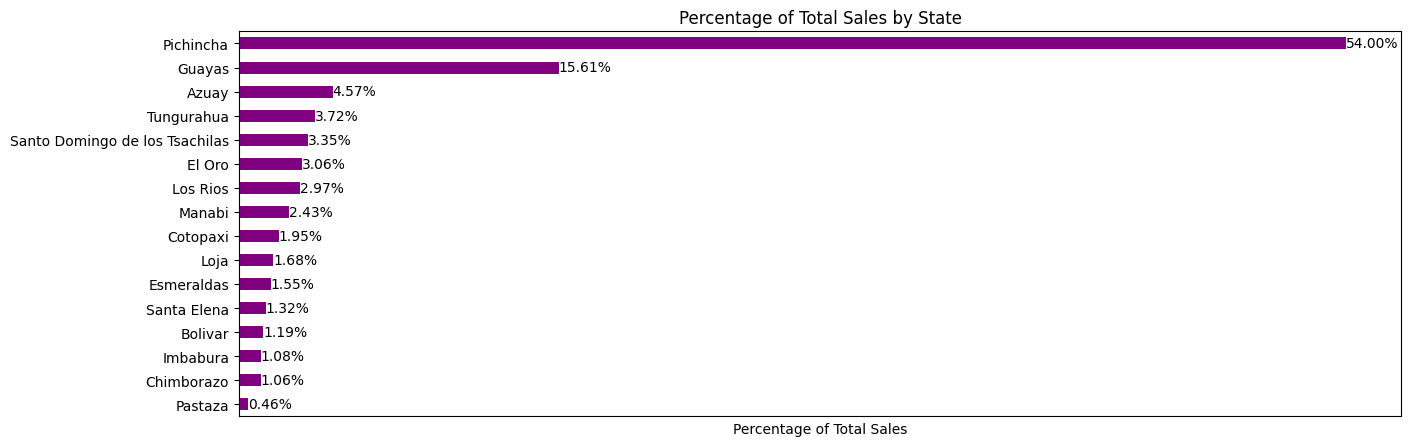

In [114]:
#Calculate total sales by state
state_sales = train_df.groupby('state')['sales'].sum().sort_values(ascending=False)

#Calculate overall total sales
overall_sales = train_df['sales'].sum()

#Calculate the percentage of each state's sales over the overall sales
percentage_sales = (state_sales / overall_sales) * 100

#Plot a horizontal bar plot to visualize the percentage of sales by state
plt.figure(figsize=(15, 5))
percentage_sales_sorted = percentage_sales.sort_values(ascending=True)
percentage_sales_sorted.plot.barh(color='purple')

#Add labels to the bars
for index, value in enumerate(percentage_sales_sorted):
    plt.text(value, index, f'{value:.2f}%', ha='left', va='center')

plt.title('Percentage of Total Sales by State')
plt.xlabel('Percentage of Total Sales')
plt.xticks([])
plt.ylabel('')
plt.show()

Observations;
* Pichincha is the top-performing state by a wide margin, contributing 54% of total sales. Guayas follows as the second best with 15.61% of total sales. 
* The lowest-performing state is Pastaza, accounting for just 0.46% of total sales.

##### * By Store type

store_type
D    43,095,650.12
A    42,426,603.40
C    19,877,564.44
B    17,985,004.96
E     7,489,748.68
Name: sales, dtype: object


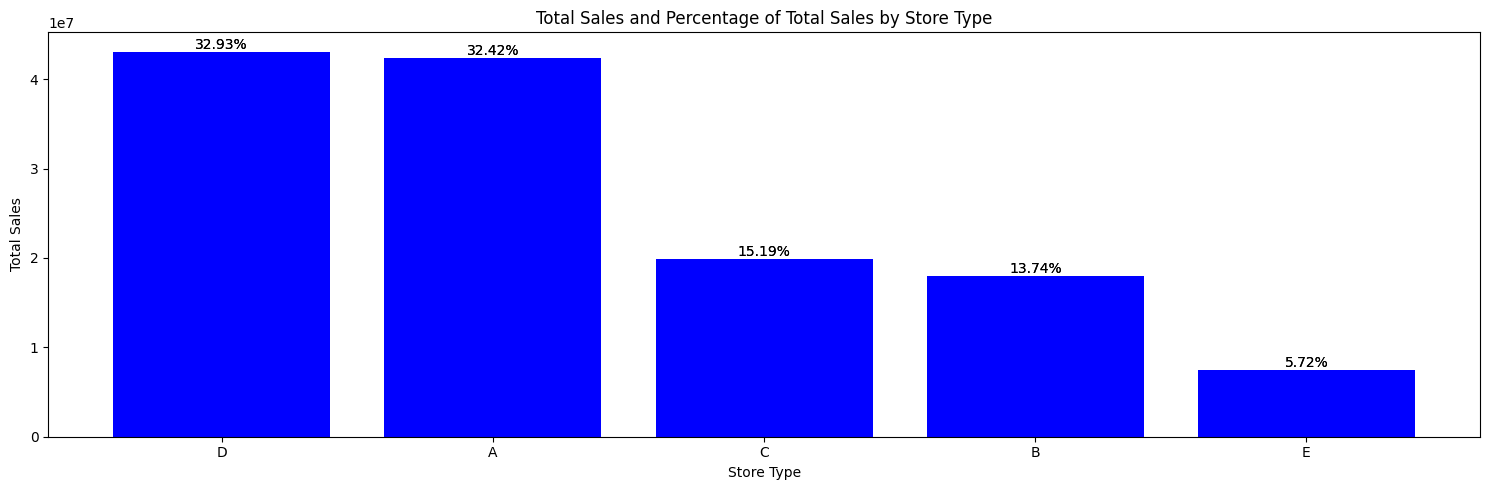

In [115]:
#Calculate total sales by store type
type_sales = train_df.groupby('store_type')['sales'].sum().sort_values(ascending=False)
print(type_sales.map('{:,.2f}'.format))

#Calculate overall total sales
overall_sales = train_df['sales'].sum()

#Calculate the percentage of each store type's sales over the overall sales
percentage_sales = (type_sales / overall_sales) * 100

#Plot a barplot to visualize the total sales and percentage of sales by store type
fig, ax = plt.subplots(figsize=(15, 5))

#Plot total sales
ax.bar(type_sales.index, type_sales, color='blue', label='Total Sales')

#Add percentage labels on top of the bars
for i, percentage in enumerate(percentage_sales):
    ax.text(i, type_sales[i] + 500, f"{percentage:.2f}%", ha='center', va='bottom', color='black')

#Add percentage of total sales as text above each bar
ax.bar_label(ax.containers[0], labels=[f"{percentage:.2f}%" for percentage in percentage_sales], label_type='edge', color='black')

ax.set_ylabel('Total Sales')
ax.set_xlabel('Store Type')
ax.set_title('Total Sales and Percentage of Total Sales by Store Type')
plt.tight_layout()
plt.show()

Observations;
* Store types are A and D are the best performers with 32.93% and 32.42% of sales respectively

* Store type E is the worst performer with 5.72% of sales.

#### 6. Are sales affected by promotions, oil prices and holidays?

##### * Is promotions affecting Sales?

In [117]:
#Split Promoted items and those that were not promoted

train_data['onpromotion_encoded'] = np.where(train_data['onpromotion'] >= 1, 1, 0)
train_data['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    2389559
1     611329
Name: count, dtype: int64

In [118]:
#Create a date column
train_data['date'] = train_data.index

In [119]:
# Drop index
train_data = train_data.reset_index(drop=True)

# Create DataFrame with dates from train_missing_dates
train_missing_dates_df = pd.DataFrame(train_missing_dates, columns=['date'])

# Merge train_data_cp and train_missing_dates_df using outer join on the 'date' column

merged_train_df = pd.merge(train_data, train_missing_dates_df, how='outer', on='date')

# Fill missing data using interpolation
merged_train_df['sales'].interpolate(inplace=True)

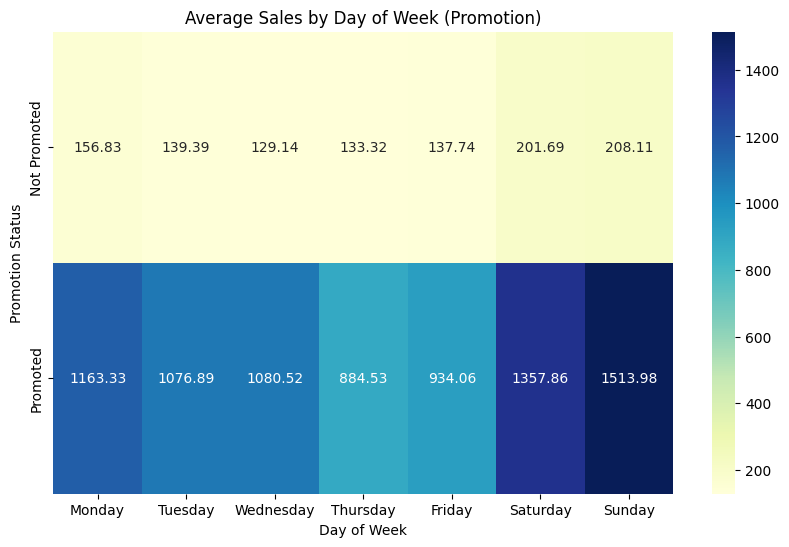

In [120]:
#Create dayofweek column
merged_train_df['dayofweek'] = merged_train_df['date'].dt.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))

#Pivot table with 'dayofweek' as rows and 'onpromotion_encoded' as columns
pivot_table = merged_train_df.pivot_table(index='onpromotion_encoded', columns='dayofweek', values='sales', aggfunc='mean')

#Plot heatmap
ax = sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.2f')

#Set x-axis labels to custom day names
ax.set_xticklabels(day_names)

#Set y-axis labels to promotion status
ax.set_yticklabels(['Not Promoted', 'Promoted'])

plt.title('Average Sales by Day of Week (Promotion)')
plt.xlabel('Day of Week')
plt.ylabel('Promotion Status')
plt.show()

Observations;
* Promotion significantly boost sales
* In all the days of the week, most sales were made from promoted products
* This suggests that targeted weekday promotions could be particularly effective in driving sales.

##### * Are Oil prices affecting Sales?

In [121]:
# Reset the index to turn the date information into a column
oil_data = oil_data.reset_index() 

In [122]:
#Check for missing_dates in the oil data
#Check first date

print(f"First date: {oil_data['date'].min()}") 

#Check Last date
print(f"Last date: {oil_data['date'].max()}")  

expected_oil_dates = pd.date_range(start=oil_data['date'].min(), end=oil_data['date'].max(), freq='D') 

print(f'Expected dates: {len(expected_oil_dates)}')
print(f'Actual dates: {len(oil_data)}')

First date: 2013-01-01 00:00:00
Last date: 2017-08-31 00:00:00
Expected dates: 1704
Actual dates: 1218


In [123]:
#Filter out the dates that are missing in the oil_data DataFrame
missing_dates = expected_oil_dates[~expected_oil_dates.isin(oil_data['date'])]
missing_df = pd.DataFrame({'date': missing_dates})

#Concatenate oil_data and missing_df using outer join on the 'date' column
merged_oil_df = pd.concat([oil_data, missing_df], ignore_index=True)
merged_oil_df['date'] = pd.to_datetime(merged_oil_df['date'])  # Convert 'date' column to datetime type
merged_oil_df = merged_oil_df.sort_values('date').reset_index(drop=True)
merged_oil_df.bfill(inplace=True)

In [124]:
#Merge oil data to train data only where oil data is available
merged_data = merged_oil_df.merge(train_data, how='left', on='date')
merged_data['dcoilwtico'].isna().sum()

np.int64(0)

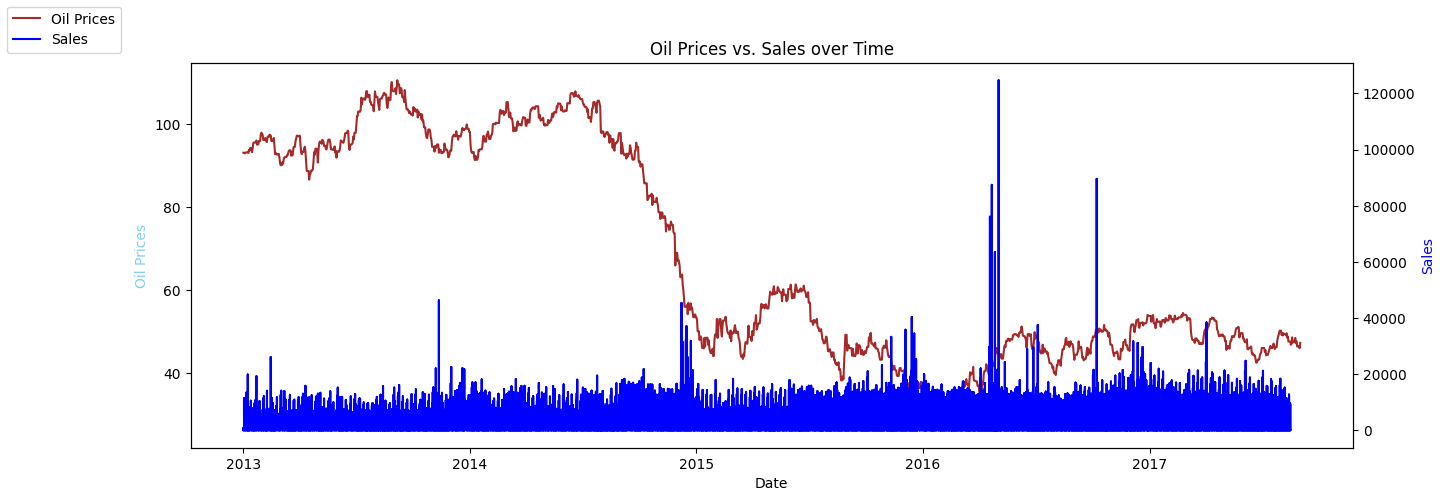

In [125]:
#Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(15, 5))

#Plot oil prices on the primary y-axis
ax1.plot(merged_data['date'], merged_data['dcoilwtico'], color='brown', label='Oil Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Prices', color='skyblue')

#Create a secondary y-axis for sales
ax2 = ax1.twinx()
ax2.plot(merged_data['date'], merged_data['sales'], color='blue', label='Sales')
ax2.set_ylabel('Sales', color='blue')

#Add a legend
fig.legend(loc='upper left')

plt.title('Oil Prices vs. Sales over Time')

#Show plot
plt.show()

In [126]:
#Check for any missing values in the merged data before doing a pearson correlation
merged_data['sales'].isna().sum()

np.int64(20)

In [127]:
#Drop rows with missing values in 'sales' columns
merged_data['sales'].isna().sum()
cleaned_data = merged_data.dropna(subset=['sales'])

#Calculate the Pearson correlation coefficient between oil prices and sales
correlation = np.corrcoef(cleaned_data['dcoilwtico'], cleaned_data['sales'])[0, 1]

print(f"Pearson correlation coefficient between oil prices and sales: {correlation}")

Pearson correlation coefficient between oil prices and sales: -0.07501254544692548


Observations;
 A negative correlation between oil prices and sales indicates that as oil prices rise, sales generally fall, and vice versa.

A Pearson correlation coefficient of around -0.075 suggests a very weak negative correlation between oil prices and sales. This implies a slight tendency for sales to decline as oil prices rise, but the relationship is not strong.

It's important to remember that correlation does not imply causation, and other factors may be influencing the relationship between oil prices and sales. Additionally, a correlation coefficient close to zero signifies a weak linear relationship, so it's crucial to consider other variables that might impact sales.

##### * Are holidays affecting Sales?

In [128]:
# Check cell values
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [129]:
# Get type of holidays
holiday_data['type'].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [130]:
# Convert the date to datetime 

holiday_data['date'] = pd.to_datetime(holiday_data['date'])

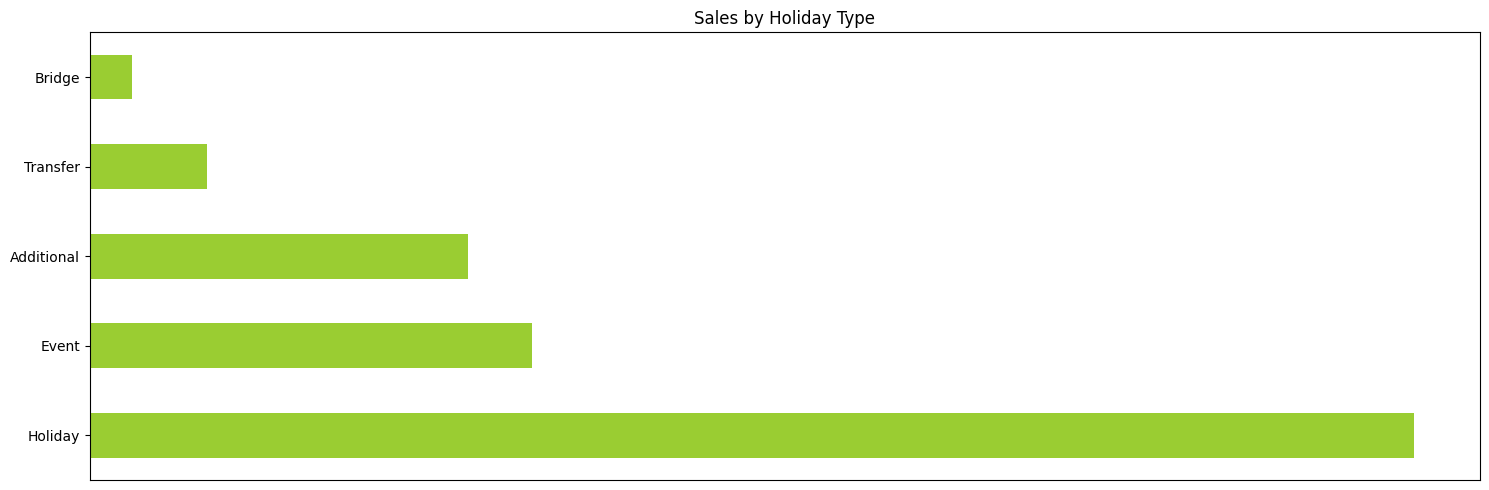

In [134]:
#Group the data by holiday type and calculate the sum of sales for each type
sales_by_holiday_type = train_df.groupby("holiday_type").agg({"sales": "sum"}).sort_values(by="sales", ascending=False)

#Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

#Plot a horizontal bar chart of the sales by holiday type
sales_by_holiday_type.plot(kind="barh", ax=ax, color='yellowgreen')

#Add a title and labels
ax.set_title("Sales by Holiday Type")
ax.set_ylabel("Holiday Type")
ax.legend().set_visible(False)
plt.xticks([])
plt.ylabel('')
plt.tight_layout()
plt.show()

Observation;

Most sales are made on regular holidays and low sales are made on Bridged holidays

#### 7. What analysis can we get from the date and its extractable features?

##### *  Sales By Month

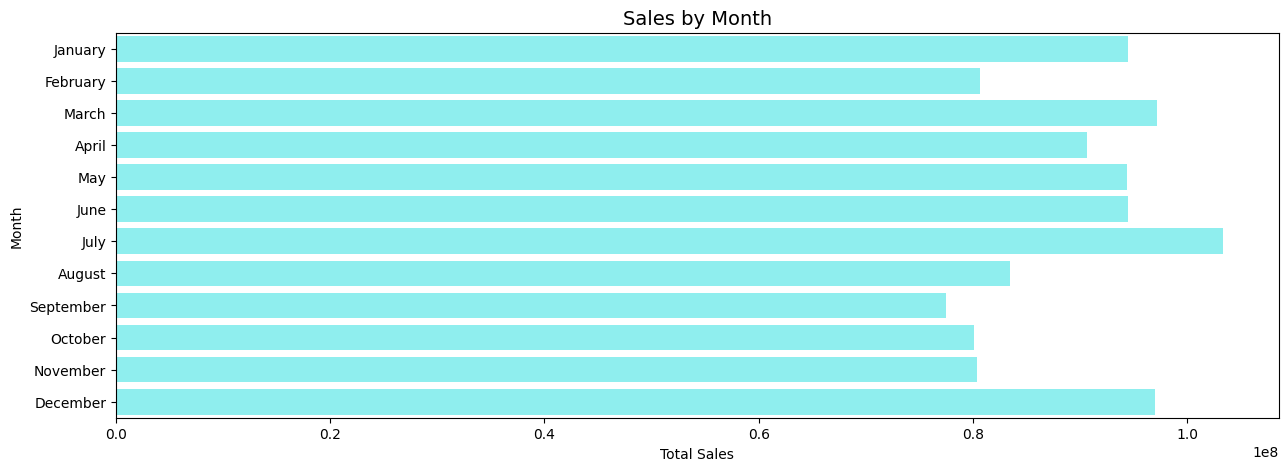

In [135]:
#Extract the month from the date column
train_data['month'] = train_data['date'].dt.month_name()

#Group by month and calculate the total sales for each month
sales_by_month = train_data.groupby('month')['sales'].sum()

#Ensure the months are in the correct order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
sales_by_month = sales_by_month.reindex(months_order)

#Plot the total sales by month
plt.figure(figsize=(15, 5))
ax = sns.barplot(y=sales_by_month.index, x=sales_by_month.values, color='cyan', alpha=0.5)
plt.title('Sales by Month', fontsize=14)
plt.xlabel('Total Sales')
plt.ylabel('Month')
plt.show()

##### * Sales by Day of the Week

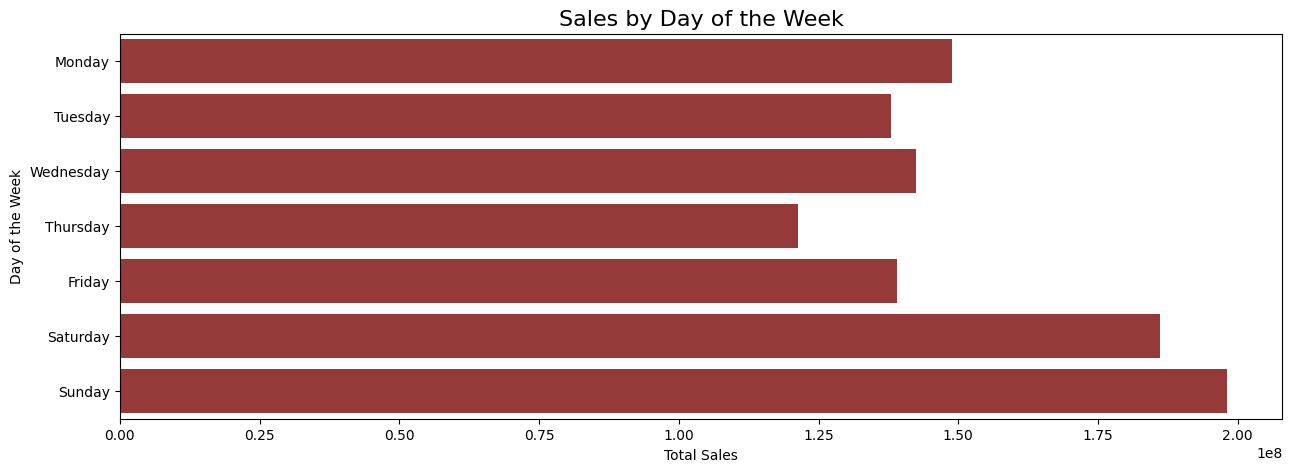

In [136]:
#Create a new column for the day of the week
train_data['day_of_week'] = train_data['date'].dt.day_name()

#Group by day of the week and calculate the total sales for each day
sales_by_day = train_data.groupby('day_of_week')['sales'].sum()

#Ensure the days are in the correct order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_day = sales_by_day.reindex(days_order)

#Plot the total sales by day of the week
plt.figure(figsize=(15, 5))
ax = sns.barplot(y=sales_by_day.index, x=sales_by_day.values, color='brown')
plt.title('Sales by Day of the Week', fontsize=16)
plt.xlabel('Total Sales')
plt.ylabel('Day of the Week')
plt.show()

Observation;

Thursdays has the least sales. Sunday and Saturday has the most sales thus the weekend.

##### * Sales by Day of the Month

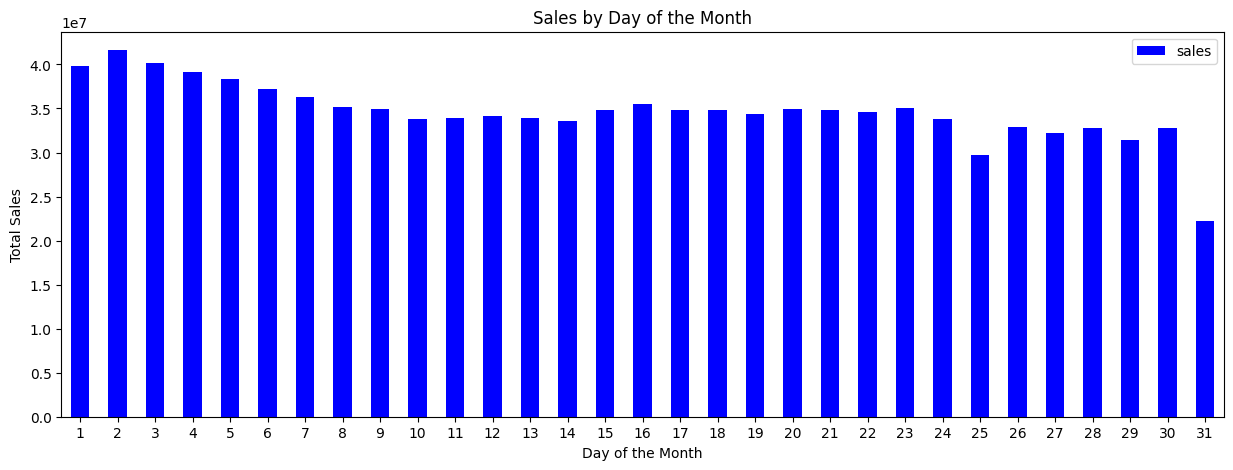

In [138]:
#Extract the day of the month from the date column
train_data['day_of_month'] = train_data['date'].dt.day

#Group by day of the month and calculate the total sales for each day
sales_by_day_of_month = train_data.groupby('day_of_month')['sales'].sum()

#Plot the total sales by day of the month
plt.figure(figsize=(15, 5))
ax = sales_by_day_of_month.plot(kind='bar', color='blue')

#Set the labels and title
ax.set_xlabel('Day of the Month')
ax.set_ylabel('Total Sales')
ax.set_title('Sales by Day of the Month')

#Customize ticks
plt.xticks(rotation='horizontal')
plt.legend(loc='upper right')

#Show the plot
plt.show()

#### 8. Which product family and stores did the promotions affect.

##### * Promotions affecting product family 

In [139]:
#Split Promoted items and those that were not promoted
train_df['onpromotion_encoded'] = np.where(train_df['onpromotion'] >= 1, 1, 0)
train_df['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    238596
1     83451
Name: count, dtype: int64

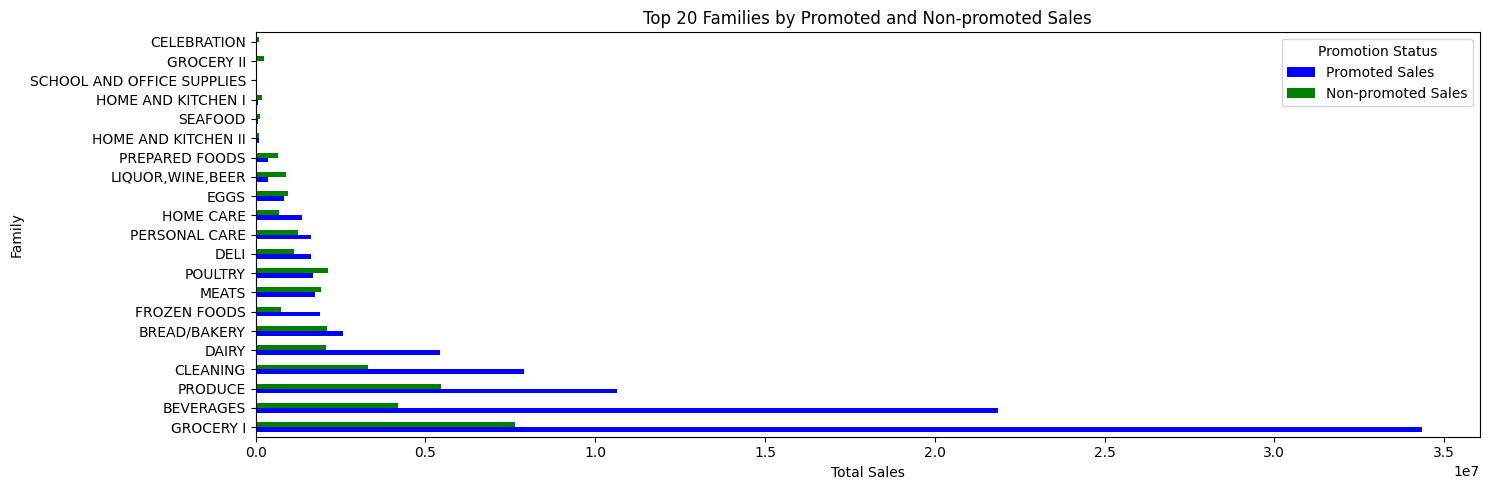

In [140]:
#Filter the DataFrame to include only rows where onpromotion_encoded is equal to 1
promoted_data = train_df[train_df['onpromotion_encoded'] == 1]
non_promoted_data = train_df[train_df['onpromotion_encoded'] == 0]

#Group by the family column and sum up the sales for each group, then sort the result
grouped_sales_promotion = promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)
non_promoted_data_grp = non_promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)

#Convert the result to a DataFrame
grouped_sales_promotion = grouped_sales_promotion.rename('Promoted Sales')
non_promoted_data_grp = non_promoted_data_grp.rename('Non-promoted Sales')

#Combine the promoted and non-promoted sales into a single DataFrame
combined_sales = pd.concat([grouped_sales_promotion, non_promoted_data_grp], axis=1).fillna(0)

#Plotting
combined_sales.plot(kind='barh', figsize=(15, 5), color=['blue', 'green'])
plt.title('Top 20 Families by Promoted and Non-promoted Sales')
plt.xlabel('Total Sales')
plt.ylabel('Family')
plt.legend(title='Promotion Status')
plt.tight_layout()
plt.show()

Grocery I is the most affected product family. The effect is positive since most sales were made from the promoted items

##### * Promotion affecting Stores

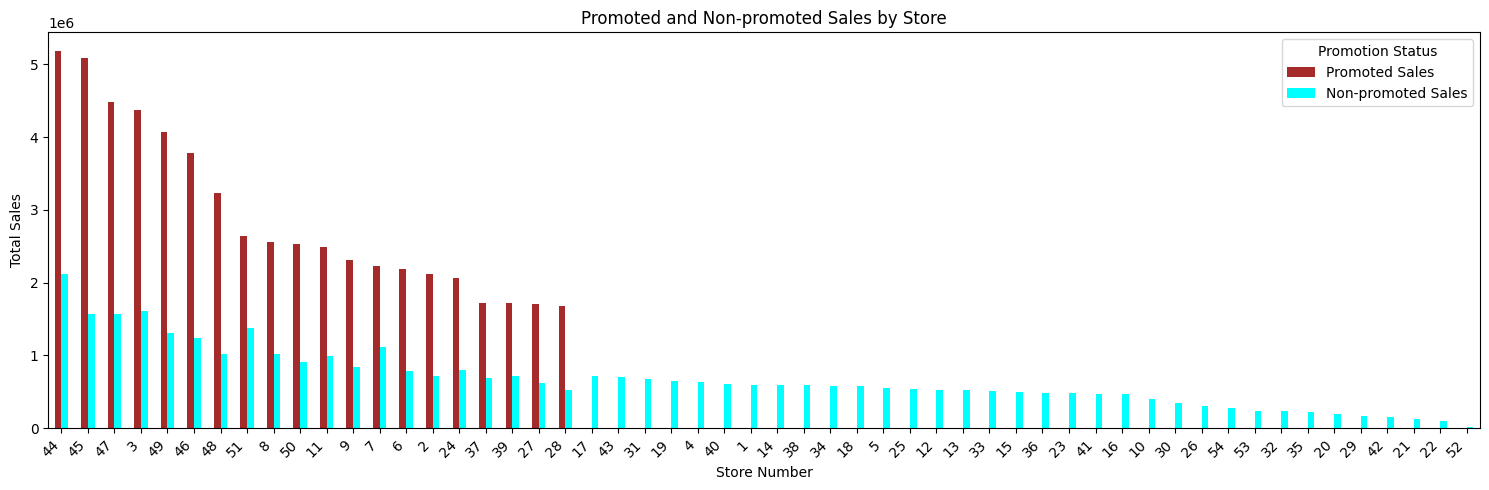

In [144]:
#Filter the DataFrame to include only rows where onpromotion_encoded is equal to 1
promoted_data = train_df[train_df['onpromotion_encoded'] == 1]
non_promoted_data = train_df[train_df['onpromotion_encoded'] == 0]

#Group by the store_nbr column and sum up the sales for each group, then sort the result
grouped_sales_promotion_str = promoted_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).head(20)
non_promoted_data_grp_str = non_promoted_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)

#Rename columns for clarity
grouped_sales_promotion_str = grouped_sales_promotion_str.rename('Promoted Sales')
non_promoted_data_grp_str = non_promoted_data_grp_str.rename('Non-promoted Sales')

#Combine the promoted and non-promoted sales into a single DataFrame
combined_sales_str = pd.concat([grouped_sales_promotion_str, non_promoted_data_grp_str], axis=1).fillna(0)

#Plotting
combined_sales_str.plot(kind='bar', figsize=(15, 5), color=['brown', 'cyan'])
plt.title('Promoted and Non-promoted Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Promotion Status')
plt.tight_layout()
plt.show()

##### The effect of promotion on store sales is a positive because most sales were from promoted items. The Positive effect of promotion on store sales is clearly evident in 'store 44' which is the store with most sales. 

### 9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

MSE (Mean Squared Error): MSE measures the average squared difference between the predicted values and the actual values. It is commonly used to evaluate regression models. A lower MSE indicates a better fit to the data.

RMSE (Root Mean Squared Error): RMSE is the square root of the MSE. It provides a measure of the average magnitude of the errors in the same units as the target variable. Like MSE, lower RMSE values indicate better model performance.

RMSLE (Root Mean Squared Logarithmic Error): RMSLE is a variation of RMSE that is often used when dealing with skewed or non-normally distributed target variables. It calculates the RMSE of the logarithm of the predicted and actual values. RMSLE is particularly useful when the target variable has a wide range, and the errors are expected to be proportional to the actual values. Lower RMSLE values indicate better performance, similar to RMSE.

Now, MAE (Mean Absolute Error) is greater than all of these metrics because MAE measures the average absolute difference between the predicted values and the actual values. It is less sensitive to outliers compared to MSE and RMSE. In some cases, MAE can be greater than MSE and RMSE because it does not penalize larger errors as significantly.

### 10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

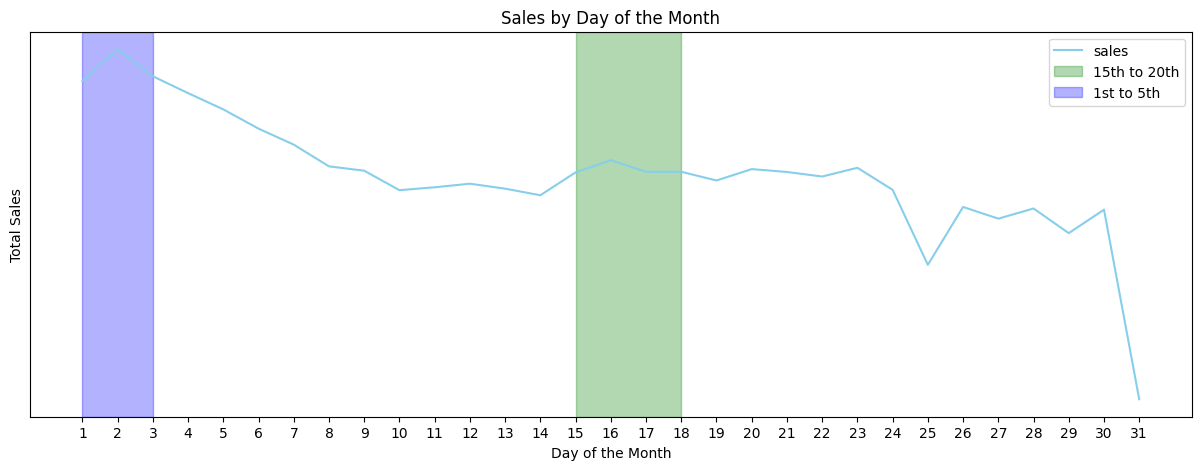

In [145]:
# Sales by day of the month
train_data['day_of_month'] = train_data['date'].dt.day
sales_by_day_of_month = train_data.groupby('day_of_month')['sales'].sum()
sales_by_day_of_month.plot(kind='line', figsize=(15, 5),
                            xlabel='Day of the Month', 
                            ylabel='Total Sales', 
                            title='Sales by Day of the Month',
                            color='skyblue')

# Highlighting different periods with different colors
plt.axvspan(15, 18, color='green', alpha=0.3, label='15th to 20th')
plt.axvspan(1, 1 + 2, color='blue', alpha=0.3, label='1st to 5th')

plt.xticks(range(1, 32), rotation='horizontal')
plt.yticks([])
plt.legend()
plt.show()

Observations;
* Following the end-of-month pay cycle, there is a noticeable surge in sales, reaching its peak around the second day of the subsequent month, gradually declining, and stabilizing by the seventh day.

* Additionally, there is a modest increase in sales post the mid-month payday, albeit less pronounced compared to the end-of-month surge.